# Simple Example

In [1]:
import sys
sys.path.append('../../../notebooks')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

from raimitigations.utils import split_data, train_model_plot_results
from raimitigations.dataprocessing import (
    Rebalance,
    EncoderOrdinal,
    EncoderOHE,
    BasicImputer,
    SeqFeatSelection,
    CatBoostSelection,
    Synthesizer,
    Rebalance
)
from download import download_datasets

In [2]:
data_dir = '../../../datasets/'
download_datasets(data_dir)
dataset =  pd.read_csv(data_dir + 'hr_promotion/train.csv')
dataset.drop(columns=['employee_id'], inplace=True)
label_col = 'is_promoted'
dataset

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


## 1 - Base Model

Split the data into training and test sets.

In [3]:
train_x, test_x, train_y, test_y = split_data(dataset, label_col, test_size=0.2)
org_train_x = train_x.copy()
org_train_y = train_y.copy()
org_test_x = test_x.copy()
org_test_y = test_y.copy()
train_x

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
3585,Operations,region_7,Bachelor's,m,sourcing,2,40,5.0,12,1,0,56
22202,Technology,region_26,Bachelor's,m,other,1,31,NaN,1,0,0,74
30915,Procurement,region_16,Bachelor's,f,other,1,31,5.0,8,1,0,71
41529,Sales & Marketing,region_15,Bachelor's,m,other,2,30,3.0,4,0,0,61
6226,Operations,region_2,Bachelor's,f,sourcing,1,28,1.0,4,1,0,64
...,...,...,...,...,...,...,...,...,...,...,...,...
23327,Operations,region_27,Bachelor's,m,other,1,29,5.0,3,1,0,55
42070,Sales & Marketing,region_29,Master's & above,m,other,1,42,3.0,15,0,0,49
22463,Sales & Marketing,region_2,Bachelor's,m,other,2,41,3.0,9,0,0,50
24252,Technology,region_7,Bachelor's,m,referred,1,28,3.0,4,0,0,78


Many models can't handle categorical data and missing values, so we cannot train the model just yet. First we need to encode all categorical data and remove missing values.

In [4]:
imputer = BasicImputer(specific_col={'previous_year_rating': {	'missing_values':np.nan, 
																'strategy':'constant', 
																'fill_value':-100 } } )
encoder = EncoderOrdinal(categories={'education': ["Below Secondary", "Bachelor's", "Master's & above"]})

imputer.fit(train_x)
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

train_x

No columns specified for imputation. These columns have been automatically identified:
['education', 'previous_year_rating']


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
3585,Operations,region_7,Bachelor's,m,sourcing,2,40,5.0,12,1,0,56
22202,Technology,region_26,Bachelor's,m,other,1,31,-100.0,1,0,0,74
30915,Procurement,region_16,Bachelor's,f,other,1,31,5.0,8,1,0,71
41529,Sales & Marketing,region_15,Bachelor's,m,other,2,30,3.0,4,0,0,61
6226,Operations,region_2,Bachelor's,f,sourcing,1,28,1.0,4,1,0,64
...,...,...,...,...,...,...,...,...,...,...,...,...
23327,Operations,region_27,Bachelor's,m,other,1,29,5.0,3,1,0,55
42070,Sales & Marketing,region_29,Master's & above,m,other,1,42,3.0,15,0,0,49
22463,Sales & Marketing,region_2,Bachelor's,m,other,2,41,3.0,9,0,0,50
24252,Technology,region_7,Bachelor's,m,referred,1,28,3.0,4,0,0,78


In [5]:
encoder.fit(train_x)
train_x = encoder.transform(train_x)
test_x = encoder.transform(test_x)
train_x

No columns specified for encoding. These columns have been automatically identfied as the following:
['department', 'region', 'education', 'gender', 'recruitment_channel']


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
3585,4,31,1,1,2,2,40,5.0,12,1,0,56
22202,8,18,1,1,0,1,31,-100.0,1,0,0,74
30915,5,7,1,0,0,1,31,5.0,8,1,0,71
41529,7,6,1,1,0,2,30,3.0,4,0,0,61
6226,4,11,1,0,2,1,28,1.0,4,1,0,64
...,...,...,...,...,...,...,...,...,...,...,...,...
23327,4,19,1,1,0,1,29,5.0,3,1,0,55
42070,7,21,2,1,0,1,42,3.0,15,0,0,49
22463,7,11,1,1,0,2,41,3.0,9,0,0,50
24252,8,31,1,1,1,1,28,3.0,4,0,0,78


 Now we create the model and train it using the training set. In the sequence, test its performance over the test set. 


TEST SET:



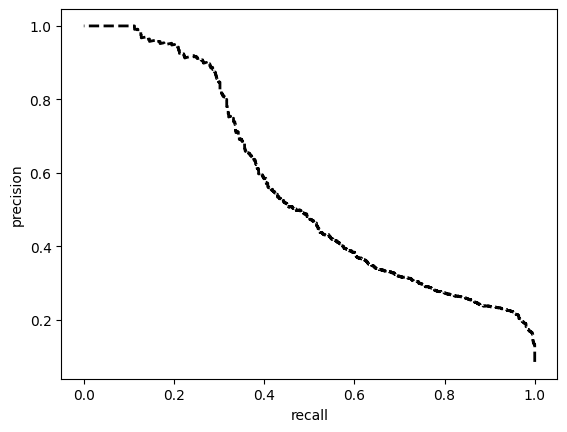

[[6965 3063]
 [  49  885]]


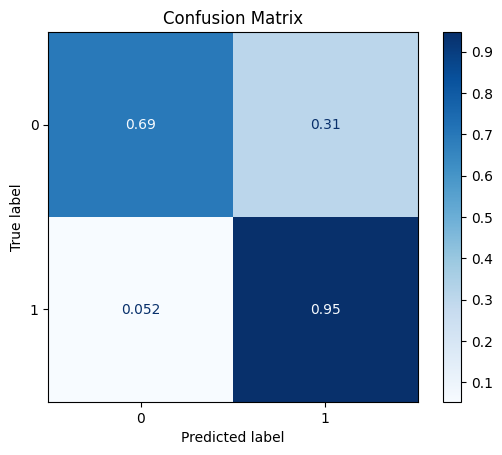

ROC AUC: 0.901447520817514
Precision: 0.9275053286524632
Recall: 0.7161101988688195
F1: 0.7786387379287758
Accuracy: 0.7161101988688195
Optimal Threshold (ROC curve): 0.10922731459140778
Optimal Threshold (Precision x Recall curve): 0.19653265178203583
Threshold used: 0.10922731459140778


In [6]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

## 2 - Feature Selection

In [7]:
from sklearn.neighbors import KNeighborsClassifier

feat_sel = SeqFeatSelection(scoring='f1', n_jobs=4)
feat_sel.fit(X=train_x, y=train_y)
feat_sel.get_selected_features()

No columns specified for imputation. These columns have been automatically identified:
[]
No columns specified for encoding. These columns have been automatically identfied as the following:
[]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    1.7s finished

[2022-10-24 09:26:50] Features: 1/12 -- score: 0.19587753570720215[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    0.3s finished

[2022-10-24 09:26:50] Features: 2/12 -- score: 0.5014459301770559[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished

[2022-10-24 09:26:50] Features: 3/12 -- score: 0.5011818840084907[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.3s finished

[2022-10-24 09:26:51] Features: 4/12 -- score: 0.49897821342

['department', 'avg_training_score']

In [8]:
train_x = feat_sel.transform(train_x)
test_x = feat_sel.transform(test_x)
train_x

,department,avg_training_score
3585,4,56
22202,8,74
30915,5,71
41529,7,61
6226,4,64
...,...,...
23327,4,55
42070,7,49
22463,7,50
24252,8,78



TEST SET:



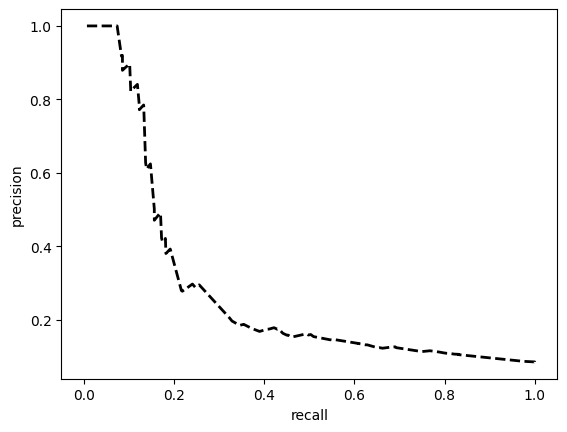

[[7557 2471]
 [ 464  470]]


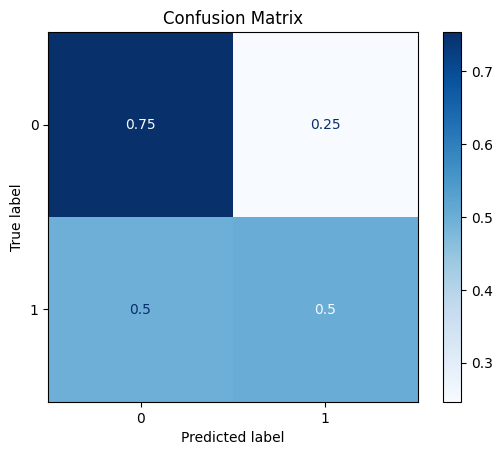

ROC AUC: 0.6715084273669699
Precision: 0.8754936071400544
Recall: 0.7322568874293012
F1: 0.786707561606923
Accuracy: 0.7322568874293012
Optimal Threshold (ROC curve): 0.11239561438560486
Optimal Threshold (Precision x Recall curve): 0.12098430097103119
Threshold used: 0.11239561438560486


In [9]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

## 3 - Generating Synthetic Data + Feature Selection

In [10]:
dataset[label_col].value_counts(normalize=True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

In [11]:
train_df = org_train_x.copy()
train_df[label_col] = org_train_y
test_x = org_test_x
test_y = org_test_y

train_df[label_col].value_counts(normalize=True)

0    0.914838
1    0.085162
Name: is_promoted, dtype: float64

In [12]:
synth = Synthesizer(
				df=train_df,
				label_col=label_col,
				model='ctgan',
				epochs=150,
				load_existing=False
			)
synth.fit()
balance_train = synth.transform(df=train_df, strategy=0.3)
balance_train[label_col].value_counts(normalize=True)

/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:131: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  cluster.KMeans(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.

0    0.76924
1    0.23076
Name: is_promoted, dtype: float64

No columns specified for imputation. These columns have been automatically identified:
['education', 'previous_year_rating']
No columns specified for encoding. These columns have been automatically identfied as the following:
['department', 'region', 'education', 'gender', 'recruitment_channel']

TEST SET:



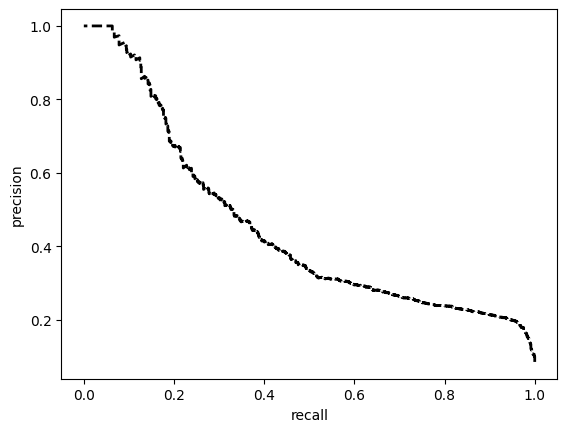

[[6645 3383]
 [  59  875]]


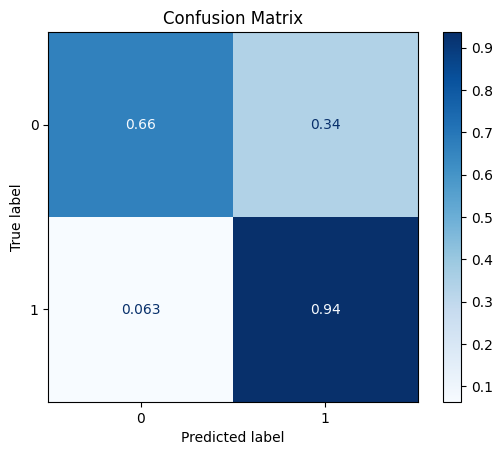

ROC AUC: 0.8713354748033131
Precision: 0.9242546298452264
Recall: 0.6860062032475825
F1: 0.7553288852785941
Accuracy: 0.6860062032475825
Optimal Threshold (ROC curve): 0.17292286455631256
Optimal Threshold (Precision x Recall curve): 0.41247978806495667
Threshold used: 0.17292286455631256


In [13]:
train_x = balance_train.drop(columns=[label_col])
train_y = balance_train[label_col]

imputer = BasicImputer(specific_col={'previous_year_rating': {	'missing_values':np.nan, 
																'strategy':'constant', 
																'fill_value':-100 } } )
encoder = EncoderOrdinal(categories={'education': ["Below Secondary", "Bachelor's", "Master's & above"]})

imputer.fit(train_x)
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

encoder.fit(train_x)
train_x = encoder.transform(train_x)
test_x = encoder.transform(test_x)

model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

No columns specified for imputation. These columns have been automatically identified:
[]
No columns specified for encoding. These columns have been automatically identfied as the following:
[]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    1.2s finished

[2022-10-24 09:41:52] Features: 1/12 -- score: 0.20662731496504683[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    0.2s finished

[2022-10-24 09:41:52] Features: 2/12 -- score: 0.3087569822982633[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished

[2022-10-24 09:41:53] Features: 3/12 -- score: 0.4803637001155439[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.3s finished

[2022-10-24 09:41:53] Features: 4/12 -- score: 0.49899840218

SELECTED FEATURES: ['department', 'education', 'recruitment_channel', 'KPIs_met >80%', 'awards_won?', 'avg_training_score']

TEST SET:



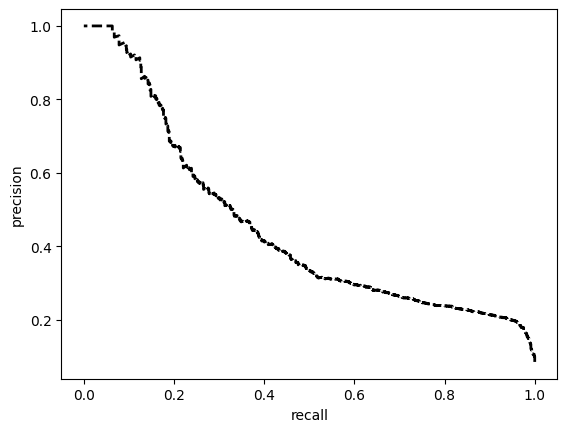

[[6645 3383]
 [  59  875]]


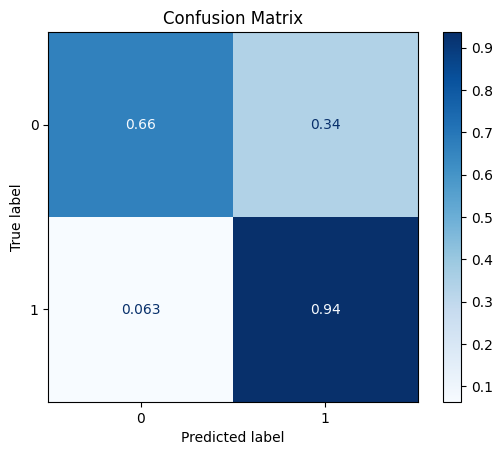

ROC AUC: 0.8713354748033131
Precision: 0.9242546298452264
Recall: 0.6860062032475825
F1: 0.7553288852785941
Accuracy: 0.6860062032475825
Optimal Threshold (ROC curve): 0.17292286455631256
Optimal Threshold (Precision x Recall curve): 0.41247978806495667
Threshold used: 0.17292286455631256


In [14]:
feat_sel = SeqFeatSelection(scoring='f1', n_jobs=4)
feat_sel.fit(X=train_x, y=train_y)
print(f"SELECTED FEATURES: {feat_sel.get_selected_features()}")
train_x_feat = feat_sel.transform(train_x)
test_x_feat = feat_sel.transform(test_x)
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

## 4 - Feature Selection + Synthetic Data

No columns specified for imputation. These columns have been automatically identified:
['education', 'previous_year_rating']
No columns specified for encoding. These columns have been automatically identfied as the following:
['department', 'region', 'education', 'gender', 'recruitment_channel']
SELECTED FEATURES: ['KPIs_met >80%', 'avg_training_score', 'department_Finance', 'department_HR', 'department_Operations', 'department_Procurement', 'department_Sales & Marketing', 'department_Technology']

TEST SET:



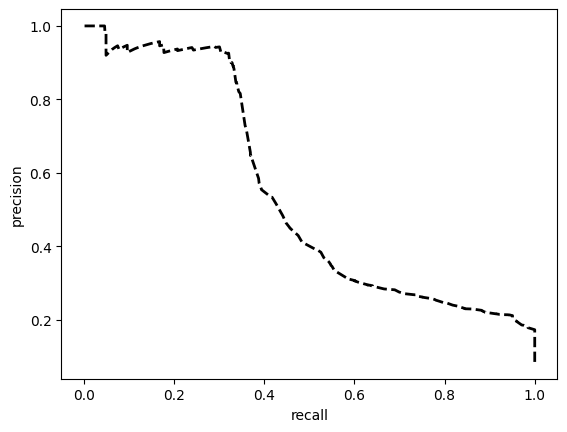

[[6715 3313]
 [  46  888]]


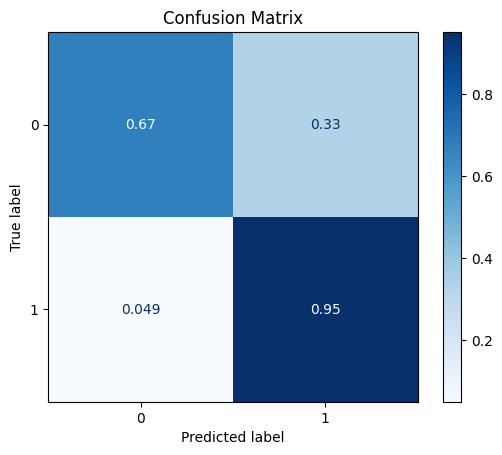

ROC AUC: 0.887314021809597
Precision: 0.9265826949701844
Recall: 0.6935778142674696
F1: 0.7612404765365726
Accuracy: 0.6935778142674695
Optimal Threshold (ROC curve): 0.0899508073925972
Optimal Threshold (Precision x Recall curve): 0.19473926723003387
Threshold used: 0.0899508073925972


In [15]:
train_x = org_train_x
train_y = org_train_y
test_x = org_test_x
test_y = org_test_y

imputer = BasicImputer(specific_col={'previous_year_rating': {	'missing_values':np.nan, 
																'strategy':'constant', 
																'fill_value':-100 } } )
encoder = EncoderOHE()

feat_sel = SeqFeatSelection(scoring='f1', transform_pipe=[imputer, encoder], n_jobs=4, verbose=False)
feat_sel.fit(X=train_x, y=train_y)
print(f"SELECTED FEATURES: {feat_sel.get_selected_features()}")

train_x = feat_sel.transform(train_x)
test_x = feat_sel.transform(test_x)

model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

In [16]:
train_df = train_x
train_df[label_col] = train_y
test_df = test_x
test_df[label_col] = test_y

synth = Synthesizer(
				df=train_df,
				label_col=label_col,
				model='ctgan',
				epochs=130,
				load_existing=False
			)
synth.fit()
balance_train = synth.transform(df=train_df, strategy=0.3)
balance_train[label_col].value_counts(normalize=True)

/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/ctgan/data_transformer.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()
Sampling conditions:   0%|          | 0/8299 [00:00<?, ?it/s]/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sdv/tabular/base.py:608: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of len

0    0.76924
1    0.23076
Name: is_promoted, dtype: float64


TEST SET:



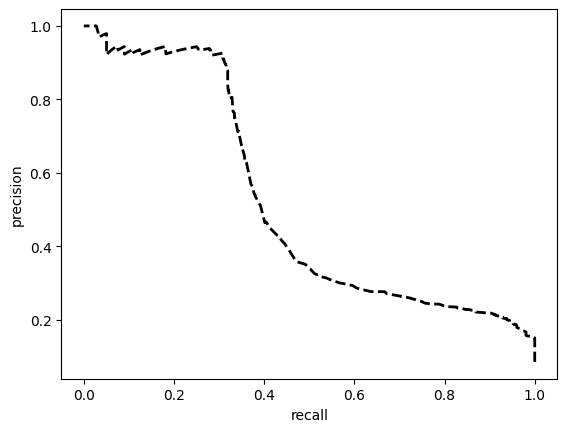

[[6992 3036]
 [  89  845]]


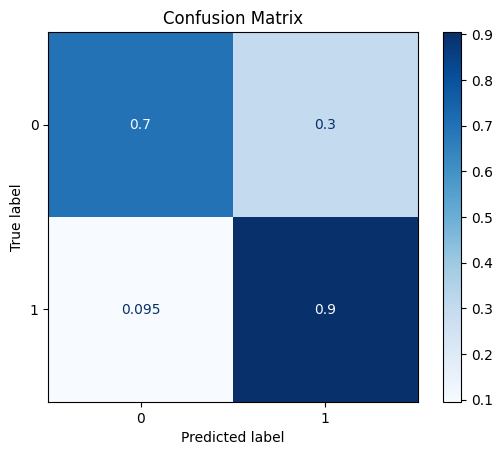

ROC AUC: 0.8770010886007402
Precision: 0.9218497529960369
Recall: 0.7149242838898011
F1: 0.7776120299645647
Accuracy: 0.7149242838898011
Optimal Threshold (ROC curve): 0.21843715012073517
Optimal Threshold (Precision x Recall curve): 0.5263636708259583
Threshold used: 0.21843715012073517


In [17]:
train_x = balance_train.drop(columns=[label_col])
train_y = balance_train[label_col]
test_x = test_df.drop(columns=[label_col])
test_y = test_df[label_col]

model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)